<a href="https://colab.research.google.com/github/jalanvatsal/Sentiment-Geometry-with-Embedding-Vectors/blob/main/Sentiment_Geometry_with_Embedding_Vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**


- This project aims to investigate how sentiment is encoded within GPT's embedding space and whether emotional states can be represented effectively as vectors. By exploring the potential for predictable transformations between various emotional states, the goal is to understand whether sentiment can be manipulated in a structured, vector-based manner. This exploration seeks to uncover the feasibility of sentiment shifts across neutral, positive, and negative emotional spectrums, leveraging GPT's powerful latent space to examine how nuanced emotions are represented and transformed.



**Research Questions to Explore 🔍**

- Can I construct a “sentiment direction” from GPT embeddings?


- What is the outcome of this embedding shift when applied to neutral or negative phrases?


- Does applying vector arithmetic result in embeddings that are semantically and emotionally close to the intended target sentiment?


In [1]:
# Upload Embeddings from Local
from google.colab import files
embeddings = files.upload()

Saving embeddings.json to embeddings.json


In [2]:
# Verify that the Embeddings are Loaded
import json

with open('embeddings.json', 'r') as f:
    embeddings = json.load(f)

# Optional: view categories
print(embeddings.keys())  # ['positive', 'negative', 'neutral']


dict_keys(['positive', 'negative', 'neutral'])


**PCA Application**

- To better understand how our sentence embeddings capture sentiment, we apply Principal Component Analysis (PCA) to reduce the high-dimensional embedding vectors to both 2D and 3D. This allows us to visually explore the structure of the data.

- Each point on the scatter plot represents a sentence, and its position reflects the reduced (PCA-transformed) embedding. The points are colored based on sentiment: green for positive, red for negative, and grey for neutral.

- If the embedding model captures sentiment meaningfully, we expect to see distinct clusters for each sentiment class. This visualization helps evaluate the effectiveness of the embeddings in separating emotional tones.



In [3]:
import numpy as np

# Initialize lists
X = []         # Matrix of embeddings
labels = []    # Sentiment labels
sentences = [] # Actual sentences (optional, for visualization)

# Flatten the dict
for sentiment, sentence_dict in embeddings.items():
    for sentence, embedding in sentence_dict.items():
        X.append(embedding)
        labels.append(sentiment)
        sentences.append(sentence)

# Convert to numpy array (for PCA)
X = np.array(X)

In [4]:
# Verify Shape
print(X.shape)

(65, 1536)


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Center Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled[:2])

[[-0.01502064  0.73151388 -0.30442956 ... -0.04982097 -0.35999394
   1.11472368]
 [ 0.32064976 -1.61657139  0.6602409  ...  0.83044809 -0.32182061
   0.08635003]]


In [6]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

In [19]:
import plotly.express as px
import pandas as pd

# Create a color palette for the 3 sentiment classes
color_map = {"positive": "green", "negative": "red", "neutral": "gray"}

# Plot PCA Visualization
df = pd.DataFrame({
    'Principal Component 1': X_reduced[:, 0],
    'Principal Component 2': X_reduced[:, 1],
    'Sentiment': labels,
    'Sentence': sentences
})

fig = px.scatter(
    df,
    x='Principal Component 1',
    y='Principal Component 2',
    color='Sentiment',
    color_discrete_map=color_map,
    hover_data=['Sentence'],  # Show sentence text on hover
    title='PCA of Sentence Embeddings by Sentiment'
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey'), opacity=0.8))

fig.show()

In [16]:
# Repeat for PCA in 3D
pca = PCA(n_components=3)
X_reduced_3D = pca.fit_transform(X_scaled)

In [17]:
# Plot
df = pd.DataFrame({
    'PC1': X_reduced_3D[:, 0],
    'PC2': X_reduced_3D[:, 1],
    'PC3': X_reduced_3D[:, 2],
    'Sentiment': labels,
    'Sentence': sentences
})

fig = px.scatter_3d(
    df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Sentiment',
    color_discrete_map=color_map,
    hover_data=['Sentence'],  # Show sentence text on hover
    title='PCA of Sentence Embeddings by Sentiment'
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey'), opacity=0.8))

fig.show()

**PCA Results**

- The PCA projections reveals distinct clustering of positive and negative sentence embeddings in both dimensional analyses, suggesting the embedding model captures sentiment well. Neutral sentences tend to lie between the two, often overlapping slightly, which aligns with their in-between tone. This is visibly apparent in both 2D and 3D plots.

**Constructing a "Sentiment Direction"**

- The PCA results reveal intriguing structure in the embedding space—prompting the question: can sentiment be captured as a consistent geometric direction within this space?

- Building on this, we ask: can we shift a negative sentence toward positivity (or vice versa) using predictable vector arithmetic?

    **Methodology**

    - To extract a negative → positive sentiment direction, we compute the vector difference between the average embeddings of negative and positive sentences. Specifically, we define negative_avg and positive_avg as the mean vectors of all negatively and positively labeled embeddings, respectively. The vector positive_avg - negative_avg then represents the directional shift from negativity to positivity in the embedding space, as conceptually illustrated below.

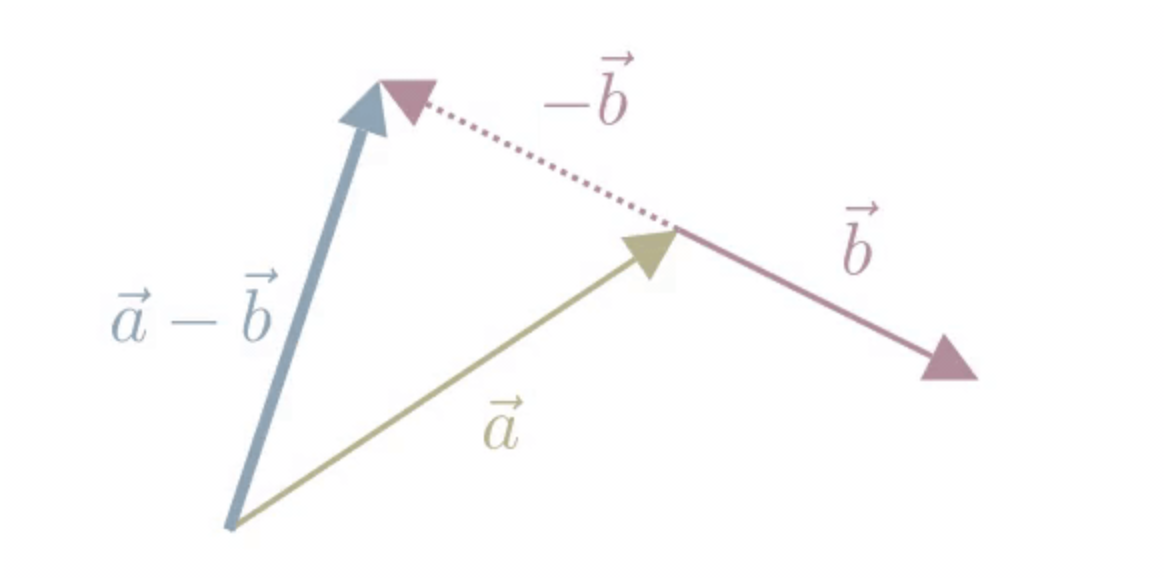

In [22]:
np_labels = np.array(labels)  # Convert list to numpy array for easy filtering

positive_avg = X[np_labels == "positive"].mean(axis=0)
negative_avg = X[np_labels == "negative"].mean(axis=0)

print("Positive avg vector:", positive_avg)
print("Negative avg vector:", negative_avg)

Positive avg vector: [ 0.00720649 -0.01121324 -0.05277958 ... -0.00729927 -0.01067429
  0.01104435]
Negative avg vector: [-0.00103827 -0.0007129  -0.03136986 ...  0.00050975 -0.01320443
  0.01598728]


In [26]:
# Contstruct Sentiment Direction
sentiment_direction = positive_avg - negative_avg

# Take Test Negative Sentence
test_sentence = "Everything is falling apart."
index = sentences.index(test_sentence)
test_embedding = X[index]

shifted_embedding = test_embedding + sentiment_direction

print(test_embedding)
print(shifted_embedding)

[-0.02972085  0.04347736  0.03294769 ...  0.00447936 -0.020564
 -0.02376253]
[-0.02147609  0.03297701  0.01153797 ... -0.00332966 -0.01803385
 -0.02870546]


**Nearest Neighbour Search**

- We will now use cosine similarity, as described below, as a distance metric to find the closest sample that is associated with our shifted embedding.

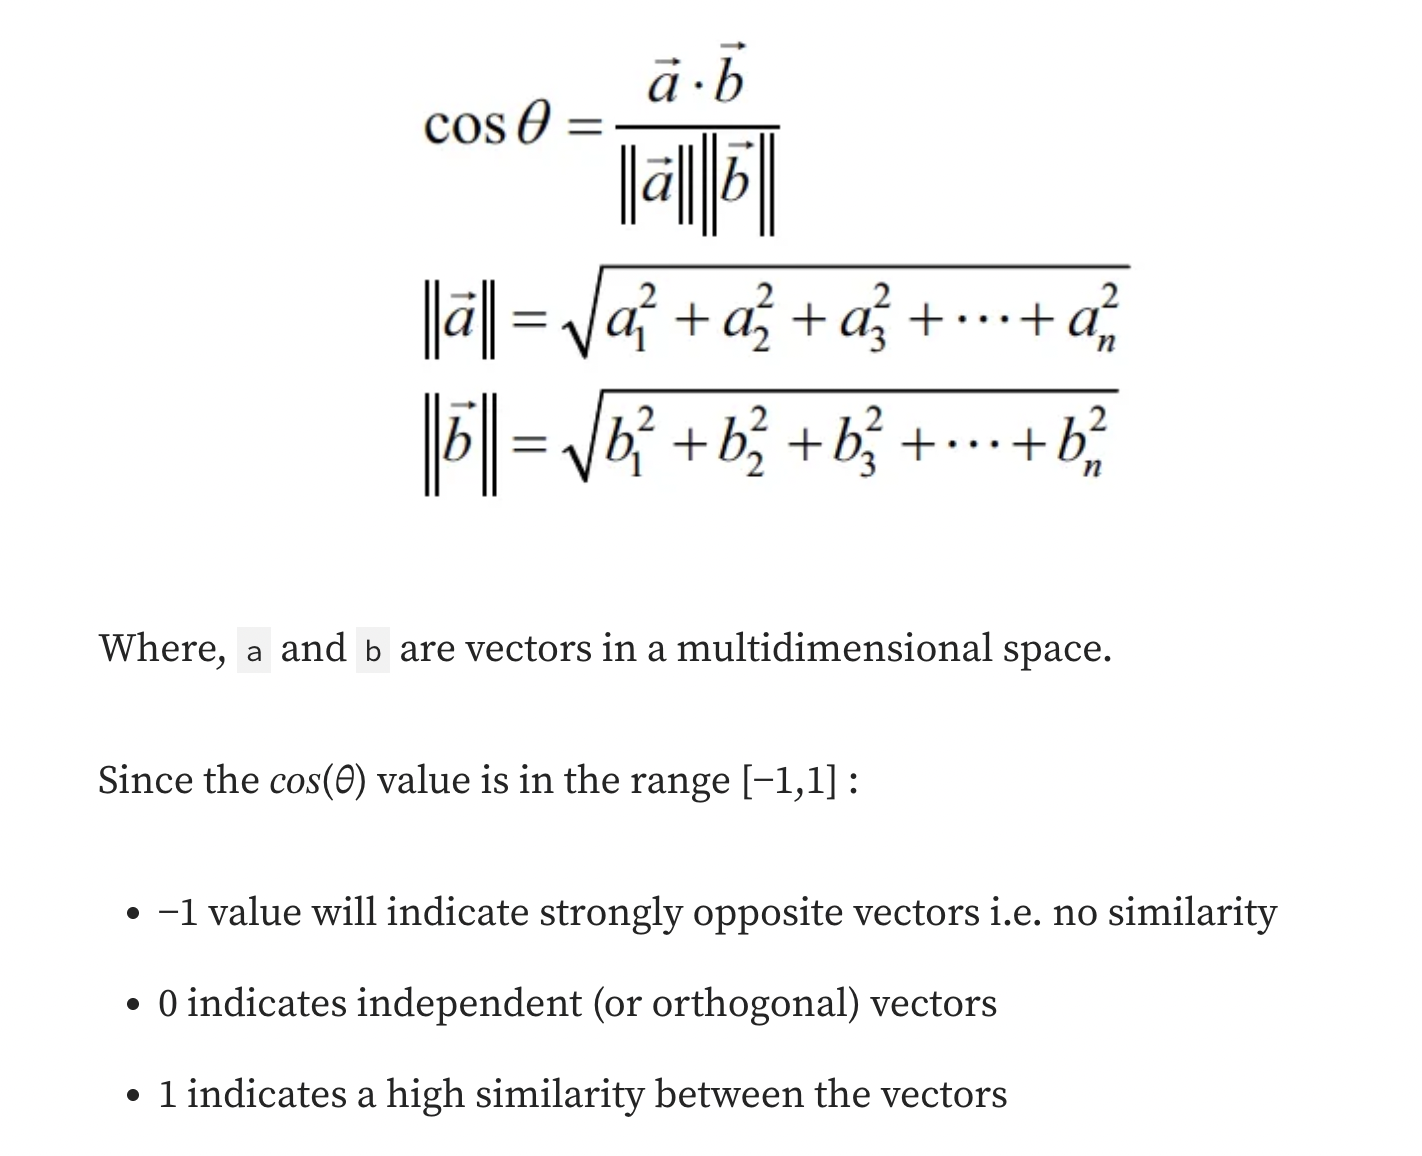

In [29]:
def cosine_sim(a,b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def find_nearest_neighbor(query_vec, embeddings, sentences, labels):
    max_sim = -1
    nearest_sentence = None
    nearest_label = None

    for embedding, sentence, label in zip(embeddings, sentences, labels):
      if sentence != test_sentence:
        sim = cosine_sim(query_vec, embedding)
        if sim > max_sim:
            max_sim = sim
            nearest_sentence = sentence
            nearest_label = label

    return nearest_sentence, nearest_label, max_sim

In [30]:
# Usage:
nearest_sentence, nearest_label, similarity = find_nearest_neighbor(
    shifted_embedding, X, sentences, labels)

print(f"Nearest sentence: {nearest_sentence}")
print(f"Sentiment label: {nearest_label}")
print(f"Cosine similarity: {similarity:.4f}")

Nearest sentence: Everything feels like it's falling into place.
Sentiment label: positive
Cosine similarity: 0.6507


**What This Might Mean?**

- Embeddings Capture Sentiment Semantics: The results suggest that the embedding space contains meaningful semantic structure related to sentiment. Sentences with similar sentiment cluster together and sentiment shifts correspond to predictable vector directions in the space.

- Vector Arithmetic Reflects Sentiment Shifts: The ability to “move” an embedding from negative to positive sentiment (or vice versa) by adding/subtracting a sentiment direction vector shows that embeddings encode compositional information that can be manipulated mathematically.

**Application Potential:**

This kind of manipulation could be used for tasks like:



*   Sentiment Modification / Transfer for Content Generation
    - Automatically improving or adapting the sentiment of text (e.g. transforming negative reviews into neutral or positive ones) can revolutionize personalized content creation and brand communication

*   Provides Insight into AI Sentiment
    - Helps explain why a sentence is classified as positive or negative by showing mathematically how far it is along the sentiment direction in embedding space.



**Limitations and Next Steps:**

The method is approximate, and results depend on data size and quality. Future work could include:

*   More robust evaluation (e.g., applying sentiment direction vector to a larger dataset).
*   Experimenting with other types of embeddings or models.
*   Formal clustering or classification to quantify PCA results.
*   Extending vector arithmetic for other semantic concepts (e.g., formality, politeness).

## 📚 References

- Jurafsky, D., & Martin, J. H. (2025). *Speech and Language Processing* (Draft, January 12, 2025). Chapter 6: Vector Semantics and Embeddings. Retrieved from [https://web.stanford.edu/~jurafsky/slp3/6.pdf](https://web.stanford.edu/~jurafsky/slp3/6.pdf)
- OpenAI. (2024). *Embeddings*. [OpenAI Platform Documentation](https://platform.openai.com/docs/guides/embeddings)
- GeeksforGeeks. *Principal Component Analysis with Python*. [Walkthrough](https://www.geeksforgeeks.org/principal-component-analysis-with-python/)
- Scikit-learn Documentation: [PCA Module](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)